In [13]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [14]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%Y-%m-%d"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)


In [15]:
#URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

stateURL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

In [16]:
raw_states = Table.read_table(stateURL)
states = list(np.unique(raw_states['state']))

In [17]:
cases = TimeTable.from_table(raw_states.pivot('state', 'date', 'cases', sum), time_col = 'date', 
                             time_less_fun=less_day)
deaths = TimeTable.from_table(raw_states.pivot('state', 'date', 'deaths', sum), time_col = 'date',
                             time_less_fun=less_day)

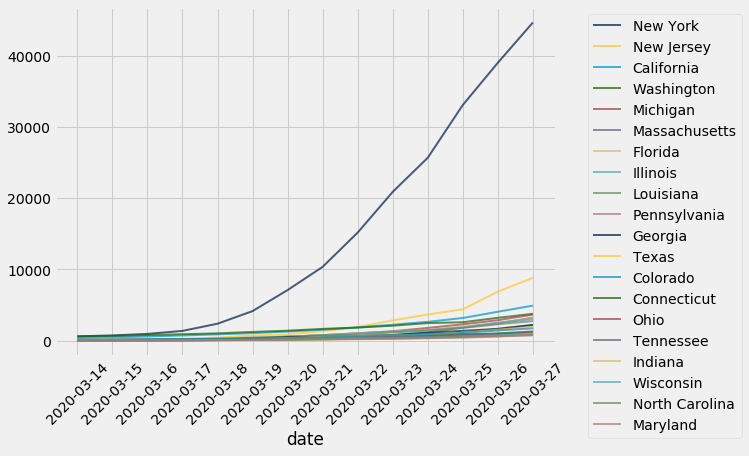

In [18]:
cases.top(20).take[-14:].plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

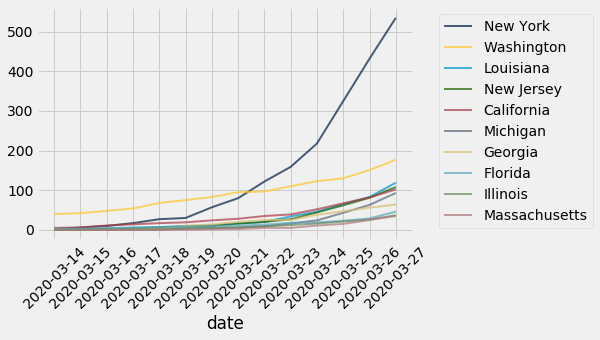

In [19]:
deaths.top(10).take[-14:].plot('date')
_ = plots.xticks(rotation=45)

In [20]:
def show_st(state='California'):
    cases.extract(state).trend().take[-20:].show()

_ = interact(show_st, state=states)

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…